In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from src.nflow_utils import *
import os
from src.utils import *
from src.nflow_utils import *
from src.generate_data_lhc import *
from src.utils import *
from src.flows import *

from nflows import transforms, distributions, flows
import torch
import torch.nn.functional as F
from nflows.distributions import uniform
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, ShuffleSplit
import argparse
import pickle
import wandb
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt


In [2]:
for i in range(20):
    np.random.seed(i)
    print(np.random.uniform(0.001,0.01))

0.005939321535345923
0.004753198042323166
0.004923954119278034
0.0059571811231711805
0.009703268551123093
0.0029979385398076555
0.009035741362924017
0.0016867746043656147
0.008860864625126346
0.0010933673849712997
0.007941885789400714
0.002622427199890923
0.0023874655814170517
0.007999321695164381
0.005625490093954213
0.008639359275417209
0.00300961971238185
0.0036519850241839877
0.006853368175656326
0.0018778024157450643


In [3]:
cd ..

/scratch/rd804/m-anode


In [4]:
data_dir = "data/lhc_co"
#nsig=1000
x_test = np.load(f'{data_dir}/x_test.npy')
label = x_test[:,-1]
true_signal = x_test[label == 1]
true_background = x_test[label == 0]
bins = np.linspace(0.0,1.0,100)
true_w = 0.006

#log_prob_S = {}
#log_prob_B = {}
#data_histogram = {}

In [5]:
# ANODE
wandb_group = 'nflows_lhc_co_nsig_scan'
wandb_job_type = 'anode_SR_RQS_1000'
wandb_try = 'try_0_'

In [6]:
CR_path = 'results/nflows_lhc_co/CR_bn_fixed_1000/try_1_0'

with open(f'{CR_path}/pre_parameters.pkl', 'rb') as f:
    pre_parameters_CR = pickle.load(f)


In [7]:
from scipy.stats import rv_histogram

In [8]:
SR_data, CR_data , true_w, sigma = resample_split('./data/lhc_co', n_sig = 1000, resample_seed = 1,resample = True)


choosing random 1000 signal events for mock_data from 70000 events
sigma=2.1156509566250077
true w: 0.006036579872060546


In [9]:
mass_bins = np.linspace(3.3,3.7,40)
rv_histogram_SR = rv_histogram(np.histogram(SR_data[:,0], bins=mass_bins))

In [14]:

model = flows_model_RQS(device=torch.device('cpu'))
masses = []

samples_anode = []
for i in range(5):
    path = f'./results/{wandb_group}/{wandb_job_type}/{wandb_try}{i}/'
    valloss = np.load(path + 'valloss_list.npy')

    lowest_epochs = np.argsort(valloss)[:1]
    print(i)
    for epoch in lowest_epochs:
        #if i==0:
       # mass_SR = rv_histogram_SR.rvs(size=1000)
        mass_SR = SR_data[:,0]
        mass_SR_tensor = torch.tensor(mass_SR.reshape(-1,1)).float()
       # path = f'wandb/{wandb_group}/{wandb_job_type}/{wandb_try}{i}/'
        model.load_state_dict(torch.load(path + f'model_S_{epoch}.pt',map_location=torch.device('cpu')))
        model.eval()
        with torch.no_grad():
            samples = model.sample(1,context=mass_SR_tensor).reshape(-1,4)
            samples_anode.append(samples)
        
        masses.append(mass_SR)
         #   samples = model.sample(1000).detach().numpy()
           # print(samples.shape)
          #  print(model)

masses = np.array(masses).reshape(-1,1)
masses = torch.tensor(masses).float()

samples_anode = np.array(samples_anode)
samples_anode = np.concatenate(samples_anode,axis=0)
samples_anode = torch.tensor(samples_anode).float()


0
1
2
3
4


/tmp/ipykernel_27359/3422805897.py:31: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  samples_anode = np.array(samples_anode)
/tmp/ipykernel_27359/3422805897.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  samples_anode = np.array(samples_anode)


In [13]:
samples_anode.shape

torch.Size([2441780, 4])

In [15]:
samples_with_mass = torch.hstack([masses,samples_anode,torch.ones((len(masses),1))])
samples_actual = inverse_transform(samples_with_mass,pre_parameters_CR)

In [17]:
config_file = 'scripts/DE_MAF_model.yml'
valloss = np.load(f'{CR_path}/valloss_list.npy')

lowest_epochs = np.argsort(valloss)[:5]
samples_background = []
masses = []
for epoch in lowest_epochs:
   # mass_SR = rv_histogram_SR.rvs(size=10000)
    #mass_SR_tensor = torch.tensor(mass_SR.reshape(-1,1)).float()
    mass_SR = SR_data[:,0]
    mass_SR_tensor = torch.tensor(mass_SR.reshape(-1,1)).float()
    model_B = DensityEstimator(config_file, eval_mode=True, load_path=f"{CR_path}/model_CR_{epoch}.pt")
    samples = model_B.model.sample(len(mass_SR_tensor),cond_inputs=mass_SR_tensor).detach().numpy()
    samples_background.append(samples)
    masses.append(mass_SR)

masses = np.array(masses).reshape(-1,1)
masses = torch.tensor(masses).float()

samples_background = np.array(samples_background)
samples_background = np.concatenate(samples_background,axis=0)
samples_background = torch.tensor(samples_background).float()

DensityEstimator has 274800 parameters
Loading model parameters from results/nflows_lhc_co/CR_bn_fixed_1000/try_1_0/model_CR_60.pt
DensityEstimator has 274800 parameters
Loading model parameters from results/nflows_lhc_co/CR_bn_fixed_1000/try_1_0/model_CR_79.pt
DensityEstimator has 274800 parameters
Loading model parameters from results/nflows_lhc_co/CR_bn_fixed_1000/try_1_0/model_CR_45.pt
DensityEstimator has 274800 parameters
Loading model parameters from results/nflows_lhc_co/CR_bn_fixed_1000/try_1_0/model_CR_44.pt
DensityEstimator has 274800 parameters
Loading model parameters from results/nflows_lhc_co/CR_bn_fixed_1000/try_1_0/model_CR_48.pt


In [18]:
samples_with_mass = torch.hstack([masses,samples_background,torch.ones((len(masses),1))])
samples_background_actual = inverse_transform(samples_with_mass,pre_parameters_CR)

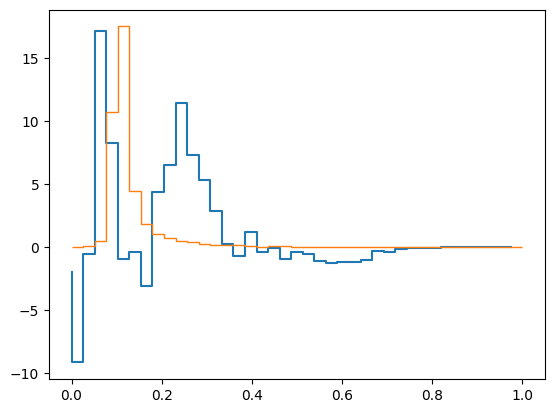

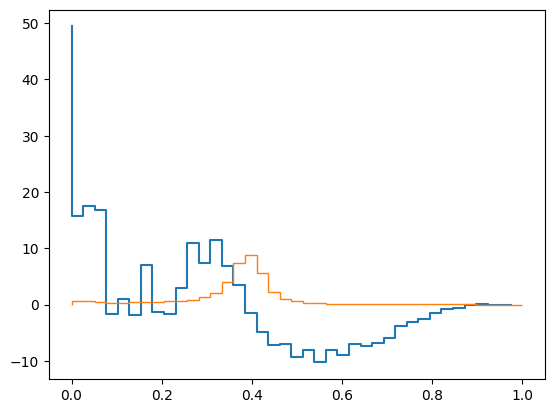

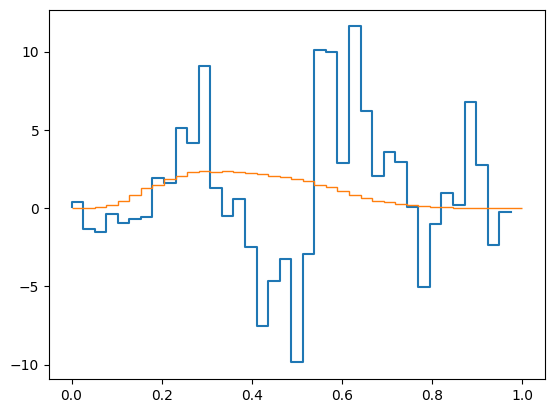

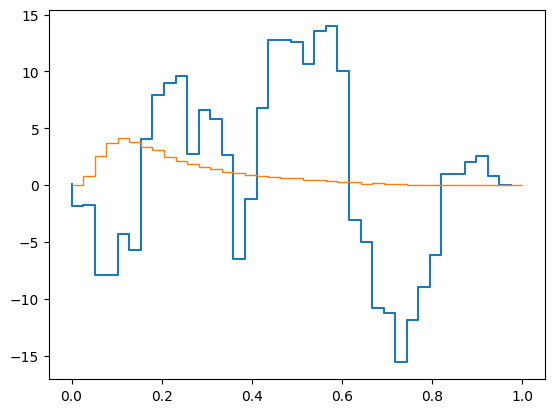

In [19]:
bins = np.linspace(0.0,1.0,40)

for i in range(1,5,1):
    hist_back,_ = np.histogram(samples_background_actual[:,i],bins=bins,density=True)
    hist_data,_ = np.histogram(samples_actual[:,i],bins=bins,density=True)

    hist_sig = (hist_data - hist_back*(1-true_w))/true_w

    plt.step(bins[:-1],hist_sig,label='signal')
    plt.hist(true_signal[:,i],bins=bins,label='true signal',histtype='step',density=True)
   # plt.show()


   # plt.hist(samples_background_actual[:,i],bins=bins,label='background',histtype='step',density=True)
   # plt.hist(samples_actual[:,i],bins=bins,label='signal',histtype='step',density=True)
    plt.show()

In [20]:
#plt.hist(samples_actual[:,1], bins=60, density=True, histtype='step', label='ANODE')
#plt.show()
_data, _ , _, _ = resample_split('./data/lhc_co', n_sig = 1000, resample_seed = 1,resample = True)

background = np.load(f'{data_dir}/extrabkg_train_val.npy')

data = np.concatenate([_data,background],axis=0)


choosing random 1000 signal events for mock_data from 70000 events
sigma=2.1156509566250077
true w: 0.006036579872060546


In [35]:
from sklearn.preprocessing import StandardScaler

_x_test = np.load(f'{data_dir}/x_test.npy')
x_test_S = preprocess_params_transform(x_test, pre_parameters_CR)
#x_test_S[:,0]-=3.5
#scaler = StandardScaler()
#scaler.fit(data[:,0].reshape(-1,1))
#mass_transformed = scaler.transform(data[:,0].reshape(-1,1))
#data[:,0] = mass_transformed[:,0]
#mass_transformed_test = scaler.transform(x_test_S[:,0].reshape(-1,1))
#x_test_S[:,0] = mass_transformed_test[:,0]
x_test_tensor = torch.tensor(x_test_S).float()

In [21]:
data_pre = preprocess_params_transform(data, pre_parameters_CR)
data_pre_tensor = torch.tensor(data_pre).float()

data_ = inverse_transform(data_pre_tensor, pre_parameters_CR).detach().numpy()

In [36]:
x_test_ = inverse_transform(x_test_tensor,pre_parameters_CR).detach().numpy()

In [22]:
x_test = np.load(f'{data_dir}/x_test.npy')
label = x_test[:,-1]

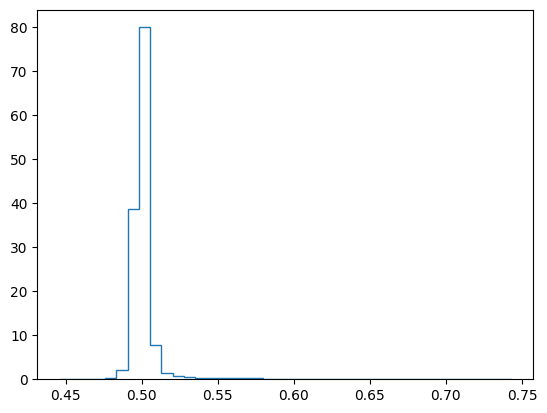

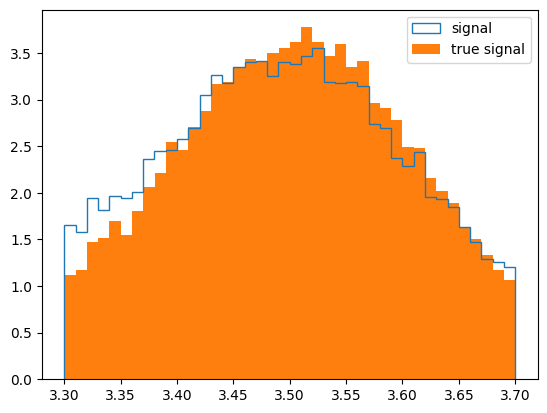

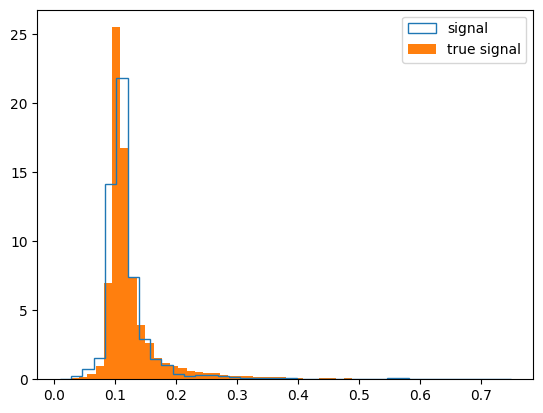

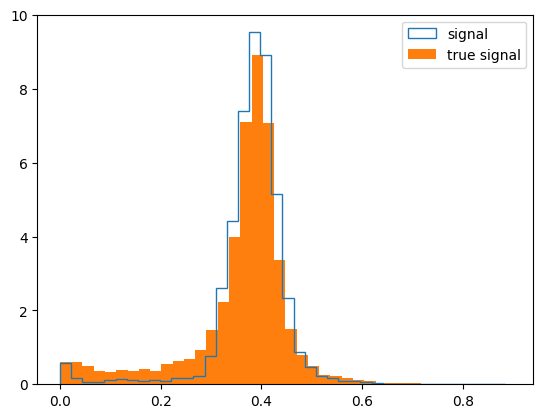

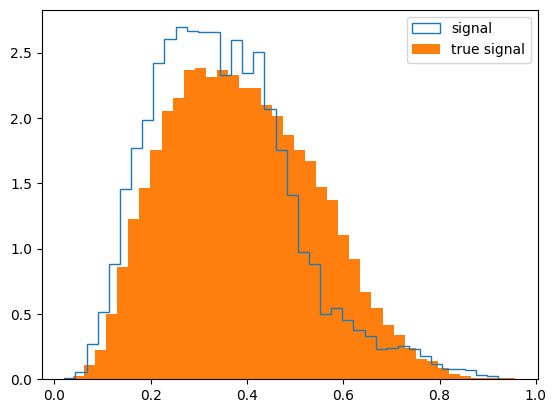

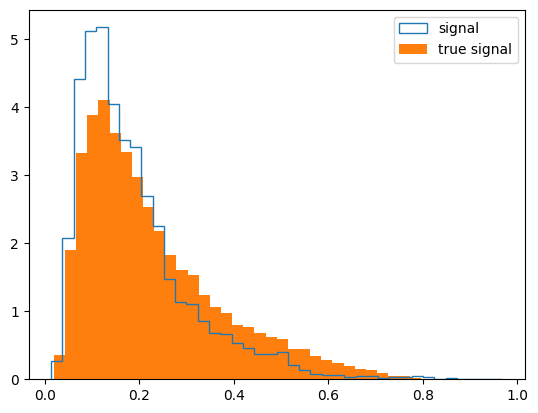

In [49]:
import pickle
wandb_group_BDT = "BDT"
wandb_project_BDT = "IAD_weighted_50_1000"
wandb_job_type_BDT = "sample"

for i in range(10):
    if i==0:
        ypred = np.load(f'results/{wandb_group_BDT}/{wandb_project_BDT}/{wandb_job_type_BDT}_{i}/ypred.npy')
        R = ypred/(1-ypred)
        x_test_cut = data_[R>1.05]
        plt.hist(ypred,bins=40,label='signal',histtype='step',density=True)
        plt.show()


for i in range(5):
    plt.hist(x_test_cut[:,i],bins=40,label='signal',histtype='step',density=True)
    plt.hist(x_test[label==1][:,i], bins=40, density=True, histtype='stepfilled', label='true signal')
    plt.legend()
    plt.show()
   # assert len(ypred) == len(x_test_S)


